# Семинар 2

# Линейная регрессия

Поработаем с линейной регрессией на практике с помощью библиотеки [scikit-learn](https://scikit-learn.org/stable/). Эта библиотека включает в себя множество алгоритмов, разные тестовые наборов данных, функции для подсчета метрик и подбора параметров, а также многое другое.

Scikit-learn появился как проект David Cournapeau на [Google Summer of Code](https://summerofcode.withgoogle.com/). Позднее к проекту присоединились другие разработчики, и первый релиз библиотеки состоялся 1 февраля 2010 года. Она быстро стала популярной засчет большого количества алгоритмов и простоты использования. Библиотека sklearn полезна для экспериментов, написания быстрых прототипов, участия в соревнованиях по анализу данных и во множестве других приложения. В тоже время, для промышленных проектов она может не подходить ввиду неоптимизированного кода и выбранного языка.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler

%matplotlib inline

In [2]:
# глобальный парметр matplotlib, который задает размер графиков
plt.rcParams['figure.figsize'] = (11.5, 8.5)

## Данные
Для демонстраций загрузим набор данных [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/Automobile). В данных присутствуют категориальные, целочисленные и вещественнозначные признаки.

In [3]:
X_raw = pd.read_csv('automobiles.csv', na_values=["?"])

In [4]:
X_raw.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


In [5]:
X_raw.shape

(205, 26)

In [6]:
y = X_raw['price']
X_raw = X_raw.drop('price', axis=1)

## Предобработка данных
Предобработка данных важна при применении любых методов машинного обучения, а в особенности для линейных моделей. В sklearn предобработку удобно делать с помощью различных модулей (например, [preprocessing](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing)) или методов библиотеки pandas.

### Заполнение пропусков
В матрице объекты-признаки могут быть пропущенные значения, и это вызовет ошибку при попытке передать такую матрицу в функцию обучения модели или даже предобработки. Если пропусков немного, можно удалить объекты с пропусками из обучающей выборки. Заполнить пропуски можно [разными способами](https://scikit-learn.org/stable/modules/impute.html), например:

* заполнить средними (mean, median);
* предсказывать пропущенные значения по непропущенным.

Последний вариант сложный и применяется редко. Для заполнения константами можно использовать метод датафрейма `fillna`, для замены средними - класс [`impute.SimpleImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) (в более старых версиях `scikit-learn` - `preprocessing.Imputer`).

Рассмотрим пример его работы (из документации).

In [7]:
# а-ля обучающая выборка
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
array1 = np.array([[7, 2, 3], [4, np.nan, 6], [10, 5, 9]])
array1

array([[ 7.,  2.,  3.],
       [ 4., nan,  6.],
       [10.,  5.,  9.]])

In [8]:
# хотим трансформировать эту выборку по обучающей
array2 = np.array([[np.nan, 2, 3], [4, np.nan, 6], [10, np.nan, 9]])
array2

array([[nan,  2.,  3.],
       [ 4., nan,  6.],
       [10., nan,  9.]])

In [9]:
imp_mean.fit(array1)
# transform - а-ля predict
imp_mean.transform(array2)

array([[ 7. ,  2. ,  3. ],
       [ 4. ,  3.5,  6. ],
       [10. ,  3.5,  9. ]])

In [10]:
imp_mean.fit_transform(array1)

array([[ 7. ,  2. ,  3. ],
       [ 4. ,  3.5,  6. ],
       [10. ,  5. ,  9. ]])

Вернемся к нашим данным.

In [15]:
X_raw

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,six,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,four,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,five,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,95.0,volvo,gas,std,four,sedan,rwd,front,109.1,...,four,141,mpfi,3.78,3.15,9.5,114.0,5400.0,23,28
201,-1,95.0,volvo,gas,turbo,four,sedan,rwd,front,109.1,...,four,141,mpfi,3.78,3.15,8.7,160.0,5300.0,19,25
202,-1,95.0,volvo,gas,std,four,sedan,rwd,front,109.1,...,six,173,mpfi,3.58,2.87,8.8,134.0,5500.0,18,23
203,-1,95.0,volvo,diesel,turbo,four,sedan,rwd,front,109.1,...,six,145,idi,3.01,3.40,23.0,106.0,4800.0,26,27


In [11]:
X_raw.isnull().any().any()

True

In [12]:
X_raw.isnull().sum()

symboling             0
normalized-losses    41
make                  0
fuel-type             0
aspiration            0
num-of-doors          2
body-style            0
drive-wheels          0
engine-location       0
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-type           0
num-of-cylinders      0
engine-size           0
fuel-system           0
bore                  4
stroke                4
compression-ratio     0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
dtype: int64

In [17]:
# для удобства работы с нашим датасетом создаем маску, указывающую на столбцы с категориальными признаками
cat_features_mask = (X_raw.dtypes == "object").values # категориальные признаки имеют тип "object"
cat_features_mask

array([False, False,  True,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False,  True,  True, False,  True,
       False, False, False, False, False, False, False])

In [18]:
# для вещественнозначных признаков заполним пропуски средними значениями
X_real = X_raw[X_raw.columns[~cat_features_mask]]
mis_replacer = SimpleImputer(strategy="mean")
X_no_nans_real = pd.DataFrame(data=mis_replacer.fit_transform(X_real), columns=X_real.columns)
# для категориальных - пустыми строками
X_cat = X_raw[X_raw.columns[cat_features_mask]].fillna("")
X_no_nans = pd.concat([X_no_nans_real, X_cat], axis=1)

In [19]:
X_no_nans.head()

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,...,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,engine-type,num-of-cylinders,fuel-system
0,3.0,122.0,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,2.68,...,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi
1,3.0,122.0,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,2.68,...,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi
2,1.0,122.0,94.5,171.2,65.5,52.4,2823.0,152.0,2.68,3.47,...,alfa-romero,gas,std,two,hatchback,rwd,front,ohcv,six,mpfi
3,2.0,164.0,99.8,176.6,66.2,54.3,2337.0,109.0,3.19,3.40,...,audi,gas,std,four,sedan,fwd,front,ohc,four,mpfi
4,2.0,164.0,99.4,176.6,66.4,54.3,2824.0,136.0,3.19,3.40,...,audi,gas,std,four,sedan,4wd,front,ohc,five,mpfi


In [20]:
X_no_nans.isnull().any().any()

False

Всегда нужно осознавать, случайны ли пропуски в каком-то признаке. Иногда факт отсутствия информации о значении признака может сам быть важным признаком, который необходимо добавить к другим признакам.

__Пример:__ предсказание возраста пользователя по данным с его телефона. Поскольку люди старшего возраста чаще пользуются простыми телефонами, факт отсутствия каких-то данных (например, истории посещенных интернет-страниц), скорее всего, будет хорошим признаком.

Для категориальных признаков рекомендуется создавать отдельную категорию, соответствующую пропущенному значению.

### Преобразование нечисловых признаков
Практически все методы машинного обучения требуют, чтобы на вход функции обучения подавалась вещественная матрица. В процессе обучения используются свойства вещественных чисел, в частности, возможность сравнения и применения арифметических операций. Поэтому, даже если формально в матрице объекты-признаки записаны числовые значения, нужно всегда анализировать, можно ли относиться к ним как к числам. 

__Пример:__ некоторые признаки могут задаваться целочисленными хешами или id (например, id пользователя соц. сети), однако нельзя сложить двух пользователей и получить третьего, исходя из их id (как это может сделать линейная модель).

К категориальным признакам, принимающим значения из неупорядоченного конечного множества $K$, часто применяют [one-hot encoding](http://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features) (вместо одного признака создают $K$ бинарных признаков - по одному на каждое возможное значение исходного признака). Правда, нужно понимать, что создание $K$ таких признаков приведет к [мультиколлинеарности](https://ru.wikipedia.org/wiki/%D0%9C%D1%83%D0%BB%D1%8C%D1%82%D0%B8%D0%BA%D0%BE%D0%BB%D0%BB%D0%B8%D0%BD%D0%B5%D0%B0%D1%80%D0%BD%D0%BE%D1%81%D1%82%D1%8C), и поэтому в зависимости от применяемой модели может быть стоит [убрать один из них](https://stats.stackexchange.com/questions/231285/dropping-one-of-the-columns-when-using-one-hot-encoding) (и оставить $K - 1$ признак).

В `sklearn` one-hot кодирование можно сделать с помощью класса [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), а можно использовать функцию [`pd.get_dummies`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html).

Следует заметить, что в новой матрице будет очень много нулевых значений. Чтобы не хранить их в памяти, можно задать параметр `OneHotEncoder(sparse=True)` или `.get_dummies(sparse=True)`, и метод вернет [разреженную матрицу](http://docs.scipy.org/doc/scipy/reference/sparse.html), в которой хранятся только ненулевые значения. Выполнение некоторых операций с такой матрицей может быть неэффективным, однако большинство методов sklearn умеют работать с разреженными матрицами.

__Вопрос__: стоит ли применять one-hot encoding для признаков с большим числом категорий (например, id)? Почему?

In [20]:
X_no_nans.shape

(205, 25)

In [21]:
X_dum = pd.get_dummies(X_no_nans, drop_first=True)
print(X_dum.shape)
X_dum.head()

(205, 66)


,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,...,num-of-cylinders_three,num-of-cylinders_twelve,num-of-cylinders_two,fuel-system_2bbl,fuel-system_4bbl,fuel-system_idi,fuel-system_mfi,fuel-system_mpfi,fuel-system_spdi,fuel-system_spfi
0,3.0,122.0,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,2.68,...,0,0,0,0,0,0,0,1,0,0
1,3.0,122.0,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,2.68,...,0,0,0,0,0,0,0,1,0,0
2,1.0,122.0,94.5,171.2,65.5,52.4,2823.0,152.0,2.68,3.47,...,0,0,0,0,0,0,0,1,0,0
3,2.0,164.0,99.8,176.6,66.2,54.3,2337.0,109.0,3.19,3.40,...,0,0,0,0,0,0,0,1,0,0
4,2.0,164.0,99.4,176.6,66.4,54.3,2824.0,136.0,3.19,3.40,...,0,0,0,0,0,0,0,1,0,0


Помимо категориальных признаков, преобразования требуют, например, строковые признаки. Их можно превращать в матрицу частот слов с помощью [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer), матрицу частот буквосочетаний фиксированной длины, можно извлекать другие признаки (например, длина строки).

### Масштабирование признаков
В ходе предобработки данных часто рекомендуется приводить все признаки к одному масштабу. Это важно по нескольким причинам:

* ускорение обучения модели;
* улучшение численной устойчивости при работе с матрицей объекты-признаки;
* для линейных моделей: интерпретация весов при признаках как меры их значимости.

(полезная ссылка: https://towardsdatascience.com/understand-data-normalization-in-machine-learning-8ff3062101f0)

Первый популярный способ масштабирования - нормализация: вычитание среднего из каждого признака и деление на стандартное отклонение ([`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) в sklearn). Второй популярный способ: вычитание минимума из каждого признака, а затем деление на разницу максимального и минимального значения ([`MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) в sklearn).

In [22]:
normalizer = MinMaxScaler()
X_real_norm_np = normalizer.fit_transform(X_dum)
X = pd.DataFrame(data=X_real_norm_np, columns=X_dum.columns)

In [23]:
X.head()

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,...,num-of-cylinders_three,num-of-cylinders_twelve,num-of-cylinders_two,fuel-system_2bbl,fuel-system_4bbl,fuel-system_idi,fuel-system_mfi,fuel-system_mpfi,fuel-system_spdi,fuel-system_spfi
0,1.0,0.298429,0.058309,0.413433,0.316667,0.083333,0.411171,0.260377,0.664286,0.290476,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.298429,0.058309,0.413433,0.316667,0.083333,0.411171,0.260377,0.664286,0.290476,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.6,0.298429,0.230321,0.449254,0.433333,0.383333,0.517843,0.343396,0.100000,0.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.8,0.518325,0.384840,0.529851,0.491667,0.541667,0.329325,0.181132,0.464286,0.633333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.8,0.518325,0.373178,0.529851,0.508333,0.541667,0.518231,0.283019,0.464286,0.633333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Добавление признаков
Особенно важным моментом для линейной регрессии является нелинейное преобразование признаков. Это позволяет использовать линейную регрессию для моделирования нелинейных зависимостей. Из популярных преобразований можно выделить следующие: полиномиальные признаки ([`PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) в sklearn), взятие логарифма, квадратного корня, применение тригонометрических функий.

Например, в нашем датасете зависимость целевой переменной от признака 'curb-weight' скорее квадратичная, чем линейная:

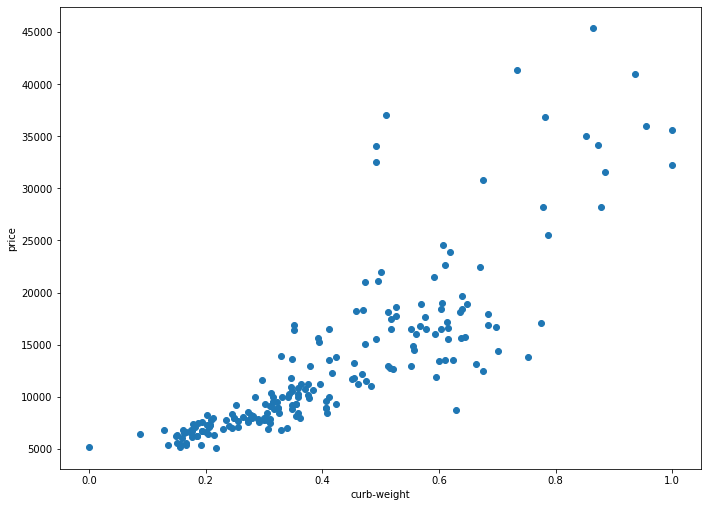

In [24]:
plt.scatter(X['curb-weight'], y)
plt.xlabel('curb-weight')
plt.ylabel('price')
plt.show()

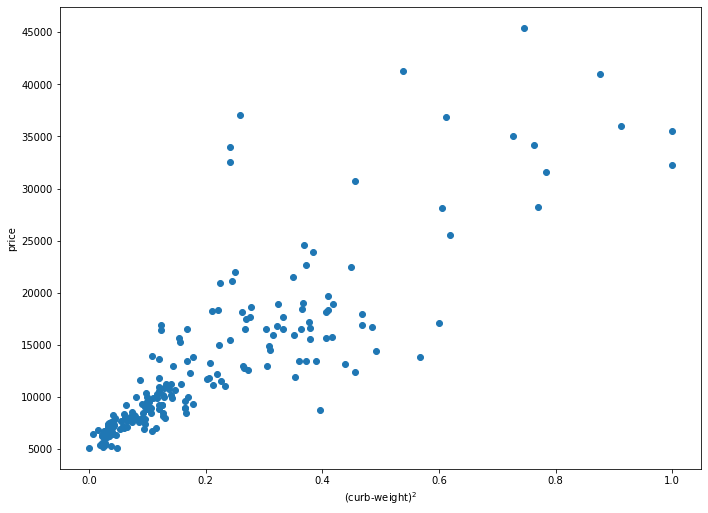

In [25]:
plt.scatter(X['curb-weight']**2, y)
plt.xlabel('(curb-weight)$^2$')
plt.ylabel('price')
plt.show()

А для признака 'highway-mpg' линеаризовать зависимость получается с помощью функции $\frac 1 {\sqrt{\cdot}}$

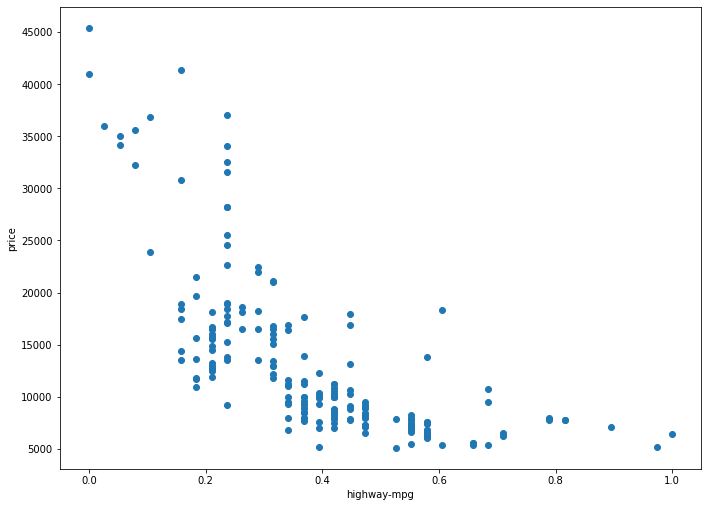

In [27]:
plt.scatter(X['highway-mpg'], y)
plt.xlabel('highway-mpg')
plt.ylabel('price')
plt.show()

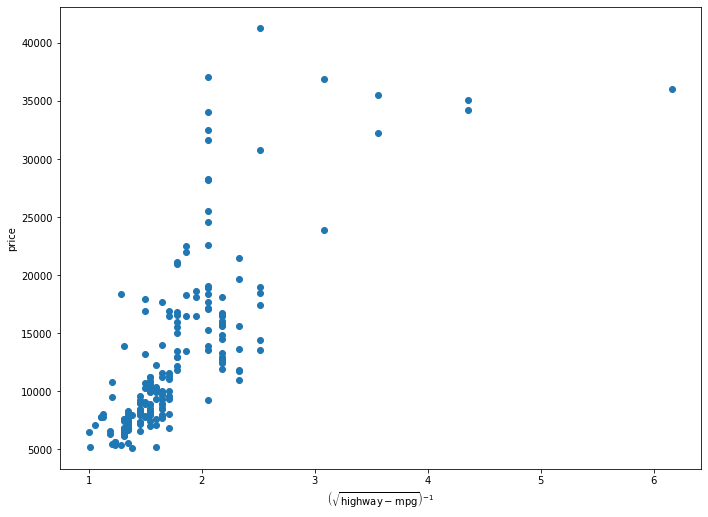

In [28]:
plt.scatter(1 / np.sqrt(X['highway-mpg']), y)
plt.xlabel('$\\left(\sqrt{\\mathrm{highway-mpg}}\\right)^{-1}$')
plt.ylabel('price')
plt.show()

Обратите внимание, что при генерации полиномиальных признаков матрица объекты-признаки может занимать очень много памяти.

## Функции потерь в регрессии

Функционал качества в задачах обучения с учителем обычно задается в виде суммы по объектам выборки:
$$Q(a, X) = \frac 1 \ell \sum_{i=1}^\ell L(y_i, a(x_i)),$$
где $L(\cdot, \cdot)$ - функция потерь, задающая штраф за разницу между предсказанием и истинным значением целевого признака.

Как отмечалось на первой лекции, функционал качества должен в первую очередь отвечать требованиям заказчика, при этом математические свойства функции потерь могут быть неудобны для оптимизации. 

__Пример:__ если мы не различаем маленькие ошибки (между 0.01 и 0.1 нет особой разницы), но зато не хотим получать большие ошибки, можно использовать следующую функцию потерь:

$$L(y_i, a(x_i)) = [| y_i - a(x_i) | < \varepsilon],$$ $\varepsilon$ - допустимая разница между предсказанием и правильным ответом.


### Среднеквадратичная и средняя абсолютная ошибка
Кроме требований заказчика, функционал качества должен учитывать математические особенности модели - например, устойчивость к шумовым объектам. В линейной регрессии функция потерь $L(y_i, a(x_i)) = (a(x_i) - y_i)^2$ не обладает этим свойством, потому что задает очень большие штрафы за большие отклонения от фактического значения. 

Рассмотрим это явление на примере. Предскажем значения признака 'make_audi' по признаку 'engine-size' с помощью линейной регрессии. Добавим к выборке два объекта-выброса и посмотрим, как изменится оптимальная с точки зрения MSE прямая.

In [29]:
X_subset = X[['engine-size', 'make_audi']].values
X_subset_modified = np.vstack((X_subset, [[1, 90], [2, 50]])) # добавление двух шумовых точек

In [30]:
def scatter_points_and_plot_line_MSE(X_subset):
    plt.scatter(X_subset[:, 0], X_subset[:, 1])   # визуализируем точки
    lr = LinearRegression()
    lr.fit(X_subset[:, 0][:, np.newaxis], X_subset[:, 1])  # найдем веса линейной модели
    grid = np.linspace(0, 2, 100)
    line = lr.predict(grid[:, np.newaxis])
    plt.plot(grid, line)   # визуализируем прямую

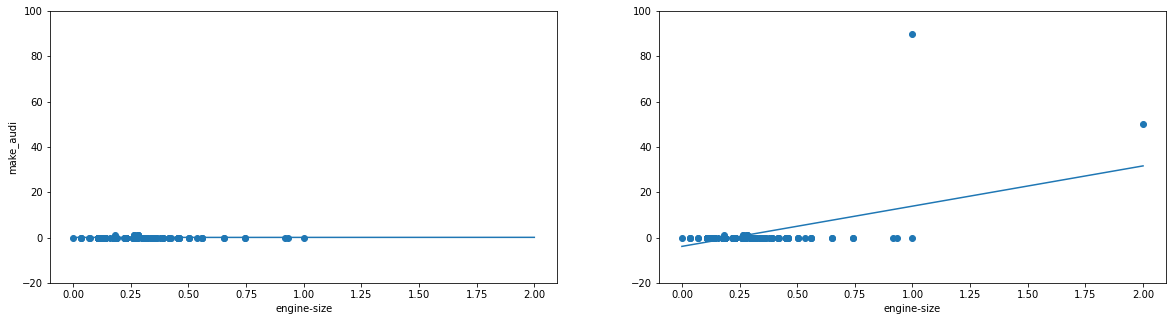

In [31]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
scatter_points_and_plot_line_MSE(X_subset)
plt.ylim(-20, 100)
plt.xlabel('engine-size')
plt.ylabel('make_audi')
plt.subplot(1, 2, 2)
scatter_points_and_plot_line_MSE(X_subset_modified)
plt.ylim(-20, 100)
plt.xlabel('engine-size')
plt.show()

Из-за шумовых объектов прямая достаточно сильно изменила наклон. Поэтому вместо MSE можно использовать Mean Absolute Error: $L(y_i, a(x_i)) = |a(x_i) - y_i|$:

Теперь обучим регрессию, оптимизируя MAE. В sklearn такая регрессия не реализована, но для примера можно использовать модуль [statsmodels](https://www.statsmodels.org/stable/index.html).

In [ ]:
!pip install statsmodels

In [32]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [33]:
def scatter_points_and_plot_line_MAE(X_subset):
    mod = smf.quantreg('f15 ~ f7', pd.DataFrame(data=X_subset, columns=["f7", "f15"])) # задаеем зависимость и передаем данные
    res = mod.fit(q=0.5)
    plt.scatter(X_subset[:, 0], X_subset[:, 1])   # визуализируем точки
    grid = np.linspace(0, 2, 100)
    plt.plot(grid, grid * res.params["f7"] + res.params["Intercept"])   # визуализируем прямую
    return mod, res

/Users/pro/anaconda/lib/python3.6/site-packages/statsmodels/regression/quantile_regression.py:205: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/pro/anaconda/lib/python3.6/site-packages/statsmodels/regression/quantile_regression.py:207: RuntimeWarning: invalid value encountered in multiply
  xtdx = np.dot(exog.T * d[np.newaxis, :], exog)
/Users/pro/anaconda/lib/python3.6/site-packages/statsmodels/regression/quantile_regression.py:218: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0


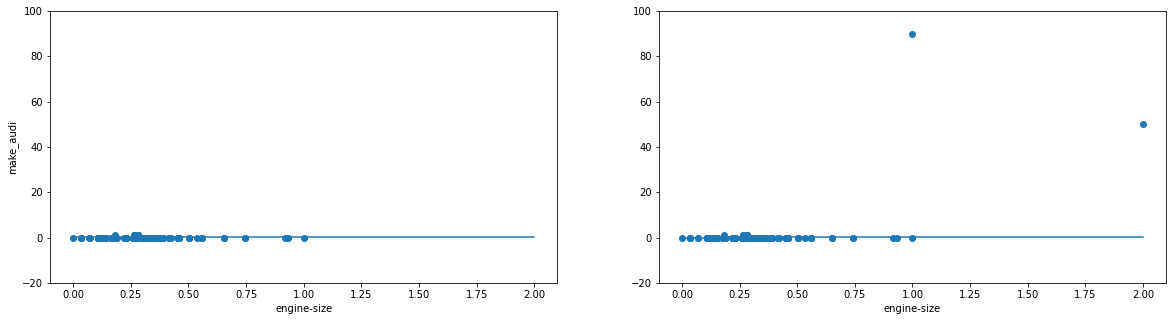

In [34]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
model, result = scatter_points_and_plot_line_MAE(X_subset)
plt.ylim(-20, 100)
plt.xlabel('engine-size')
plt.ylabel('make_audi')
plt.subplot(1, 2, 2)
model, result = scatter_points_and_plot_line_MAE(X_subset_modified)
plt.ylim(-20, 100)
plt.xlabel('engine-size')
plt.show()

Прямая не изменила направление из-за выбросов.

Попробуем добавить больше шумовых объектов:

In [37]:
np.random.seed(13)
X_subset_modified_twice = np.vstack((X_subset_modified, np.random.randint(5, size=60).reshape(-1, 2)*[1, 30])) # добавление 30 шумовых точек

/Users/pro/anaconda/lib/python3.6/site-packages/statsmodels/regression/quantile_regression.py:205: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/pro/anaconda/lib/python3.6/site-packages/statsmodels/regression/quantile_regression.py:207: RuntimeWarning: invalid value encountered in multiply
  xtdx = np.dot(exog.T * d[np.newaxis, :], exog)
/Users/pro/anaconda/lib/python3.6/site-packages/statsmodels/regression/quantile_regression.py:218: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0


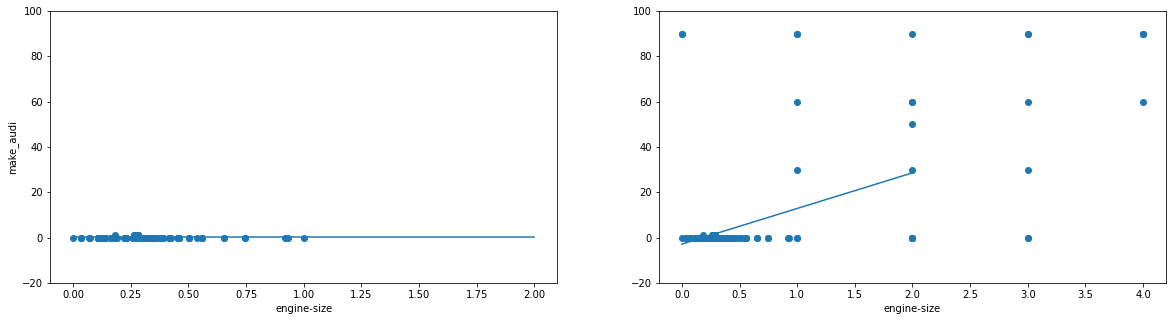

In [38]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
model, result = scatter_points_and_plot_line_MAE(X_subset)
plt.ylim(-20, 100)
plt.xlabel('engine-size')
plt.ylabel('make_audi')
plt.subplot(1, 2, 2)
model, result = scatter_points_and_plot_line_MAE(X_subset_modified_twice)
plt.ylim(-20, 100)
plt.xlabel('engine-size')
plt.show()

Прямая изменила наклон, когда мы добавили 30 (почти 15%) шумовых точек.

### Huber Loss
Иногда используют Huber Loss - "гибрид" MAE и MSE, который, как и MAE, устойчив к шумовым объектам, и как и MSE, мало штрафует малые отклонения от фактического значения целевого признака:
$$L(y_i, a(x_i)) = \phi_\varepsilon(a(x_i) - y_i)$$
$$\phi_\varepsilon(z) = \begin{cases} \frac 1 2 z^2, - \varepsilon < z < \varepsilon, \\\varepsilon (|z| - \frac 1 2 \varepsilon), иначе \\ \end{cases}$$

Оптимизация Huber Loss реализована в sklearn:

In [ ]:
from sklearn.linear_model import HuberRegressor

### Quantile Loss

В некоторых задачах штраф за ошибку зависит не только от величины абсолютного отклонения от фактического значения, но и от знака этого отклонения. Например, лучше предсказать спрос больше, чем будет по факту, чем меньше, потому что во втором случае будет потеряна прибыль. В этом случае используется квантильная регрессия со следующей функцией потерь:
$$L(y_i, a(x_i)) = \rho_\tau(y_i - x_i^T w),$$
$$\rho_\tau(z) = \begin{cases} \tau z, \quad z > 0, \\ (\tau - 1) z, \quad z \leqslant 0 \end{cases}$$
Параметр $\tau \in (0, 1)$ влияет на то, насколько различаются штрафы за положительную и отрицательную разницу.

Изобразим график квантильной функции потерь вместе с другими рассмотренными:

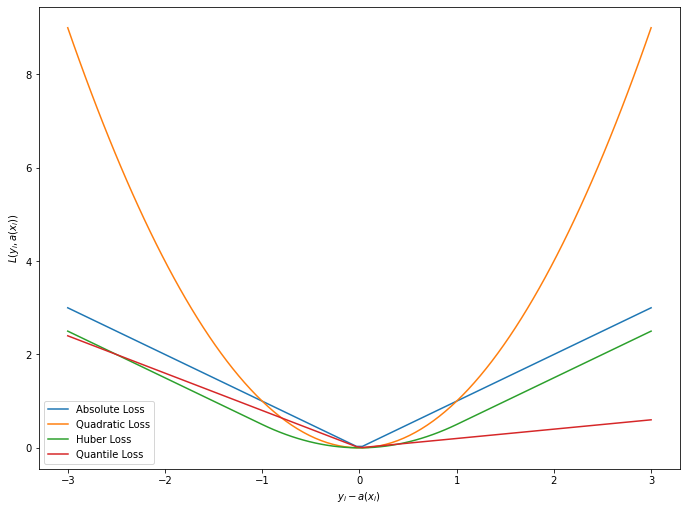

In [39]:
grid = np.linspace(-3, 3, 100)
quantile_tau = 0.2
mse_loss = grid ** 2
mae_loss = np.abs(grid)
huber_loss = 0.5 * mse_loss * (grid >= -1) * (grid <= 1) + (mae_loss - 0.5) * (grid < -1) + (mae_loss - 0.5)  * (grid > 1)
quantile_loss = quantile_tau * grid * (grid > 0) + (quantile_tau - 1) * grid * (grid <= 0)
plt.plot(grid, mae_loss, label="Absolute Loss")
plt.plot(grid, mse_loss, label="Quadratic Loss")
plt.plot(grid, huber_loss, label="Huber Loss")
plt.plot(grid, quantile_loss, label="Quantile Loss")
plt.xlabel("$y_i - a(x_i)$")
plt.ylabel("$L(y_i, a(x_i))$")
plt.legend()
plt.show()

Проследим наклон прямой в нашей одномерной задаче регрессии при изменении $\tau$:

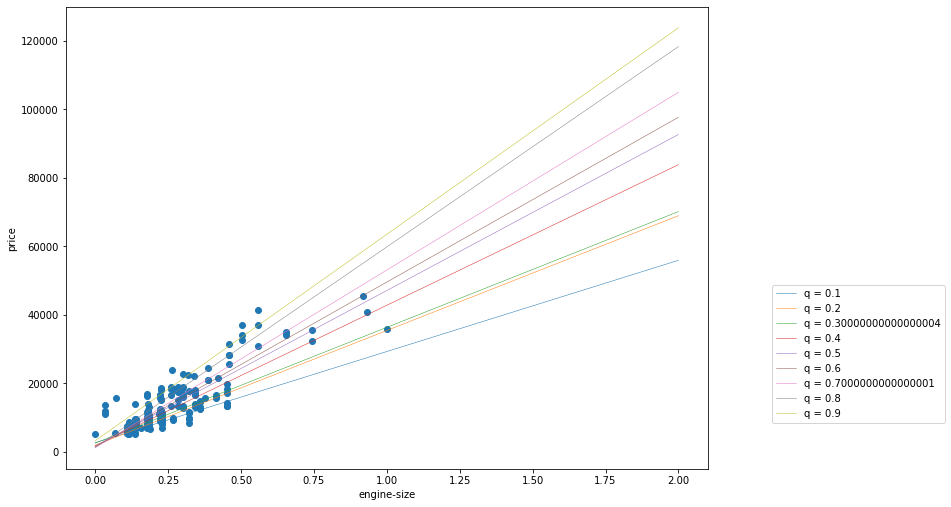

In [40]:
plt.scatter(X['engine-size'], y)
grid = np.linspace(0, 2, 100)
dat = pd.DataFrame({"x":X['engine-size'], "y":y})
mod = smf.quantreg('y ~ x', dat)
for q in np.arange(0.1, 1, 0.1):
    res = mod.fit(q=q)
    plt.plot(grid, grid * res.params["x"] + res.params["Intercept"], linewidth=0.5, label="q = "+str(q))
plt.legend(loc=(1.1, 0.1))
plt.xlabel('engine-size')
plt.ylabel('price')
plt.show()